# Bayesian Updating

This notebook will walk through a simple example of estimating a continuous variable as a function of two categorical variables. Specifically, we will see how we can not only render an estimate, but also update the estimate as we receive more data. The key takeaway will be that despite claims to the contrary, there is no such thing as a minimum sample size. Our focus should instead be on the management of uncertainty.

In [2]:
import pymc as pm
import arviz as az
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pytensor
import pytensor.tensor as pt
import pandas as pd
from typing import Dict, List, Set

## Problem Statement

Hat tip to [Gemini](gemini.google.com) for the problem statement. A software development team wants to estimate the build time (in minutes) for their software modules. They believe the build time is influenced by the module's size (Small or Large) and the server's load (Low or High).

### Variables

+ **Build Time (T):** *Continuous* - Measured in minutes. This is our dependent variable.
+ **Module Size (S):** *Categorical* - Small or Large.
+ **Server Load (L):** *Categorical* - Low or High.

### Goal

We want to estimate the distribution of T given S and L, which we'll denote as P(T∣S,L). Since T is continuous, we'll be estimating the parameters of a distribution (e.g., mean and standard deviation) rather than a simple probability.

## Data Generating Process

Normally, we would not know the true parameters for this process, because they would be unobserved. However, since this is a contrived example, and we want to understand if we are actually getting the right answer, we will set the true parameters and see if we can recover them. Suppose initially that the module size and server load are independent, and the data generating process is defined as follows:

$$ T = \beta_0 + \beta_1 S + \beta_2 L + \epsilon $$

or equivalently

$$ T \sim N(\beta_0 + \beta_1 S + \beta_2 L, \sigma_\epsilon) $$

For our DGP, our base case is a small module with low server load and $\beta = [1, 4, 5]$. In other words, when we have a small module ($S = 0$) and low server load ($L = 0$), our build time is 1 minute on average. The variance in our estimate is given by the distribution of $\epsilon$, represented directly in the first expression and via it's standard deviation ($\sigma_\epsilon$) in the second. To simulate this data, we'll leverage [PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html) because it's transparent (we'll see the computational graph) and it's heavily used by [PyMC](https://www.pymc.io/), which be our estimation package of choice. First a straightforward translation of the DGP above (note that the $1$ values capture the intercept):

$$ Y = X\beta + \epsilon = \begin{bmatrix} 1 & S & L \end{bmatrix} \begin{bmatrix} 1 \\ 4 \\ 5 \end{bmatrix} + \epsilon $$

Identity [id A] 'bt'
 └─ Add [id B]
    ├─ Sum{axes=None} [id C]
    │  └─ Mul [id D]
    │     ├─ beta{[1 4 5]} [id E]
    │     └─ Join [id F]
    │        ├─ 0 [id G]
    │        ├─ intercept{[1]} [id H]
    │        ├─ bernoulli_rv{"()->()"}.1 [id I] 'S'
    │        │  ├─ RNG(<Generator(PCG64) at 0x742879D40040>) [id J]
    │        │  ├─ NoneConst{None} [id K]
    │        │  └─ [0.2] [id L]
    │        └─ bernoulli_rv{"()->()"}.1 [id M] 'L'
    │           ├─ RNG(<Generator(PCG64) at 0x742879D404A0>) [id N]
    │           ├─ NoneConst{None} [id K]
    │           └─ [0.4] [id O]
    └─ normal_rv{"(),()->()"}.1 [id P] 'e'
       ├─ RNG(<Generator(PCG64) at 0x742879D418C0>) [id Q]
       ├─ NoneConst{None} [id K]
       ├─ 3 [id R]
       └─ 1.2 [id S]


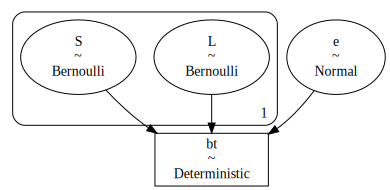

In [3]:
with pm.Model() as gen_model:
    # We are hard coding our coefficients instead of estimating them
    beta: pt.TensorConstant = pm.math.constant([1, 4, 5], name="beta")

    # Our input data includes a column of ones to accommodate the intercept
    intercept: pt.TensorConstant = pm.math.constant([1], name="intercept")
    s: pt.TensorVariable = pm.Bernoulli(p=[0.2], name="S")
    l: pt.TensorVariable = pm.Bernoulli(p=[0.4], name="L")
    data: pt.TensorVariable = pt.concatenate([intercept, s, l])

    # The data above compute the expected value, while epsilon provides the
    # variance around that value
    e: pt.TensorVariable = pm.Normal(mu=3, sigma=1.2, name="e")

    # Our simulated output is now just arithmetic given the inputs
    bt: pt.TensorVariable = pm.Deterministic("bt", pt.sum(beta * data) + e)

pytensor.dprint(gen_model.bt)
pm.model_to_graphviz(gen_model)

Now that we have our model, we can just draw samples from it, which `pymc` makes easy. Once the samples are drawn, we can examine the distribution of module size ($S$), server load ($L$), observed build time ($bt$), and variance about the expected build time conditional on module size and server load ($e$). Note how the categorical distributions, $S$ and $L$, differ from the continuous distributions $bt$ and $e$.

Sampling: [L, S, e]


array([[<Axes: title={'center': 'L\n0'}>,
        <Axes: title={'center': 'S\n0'}>, <Axes: title={'center': 'e'}>],
       [<Axes: title={'center': 'bt'}>, <Axes: >, <Axes: >]], dtype=object)

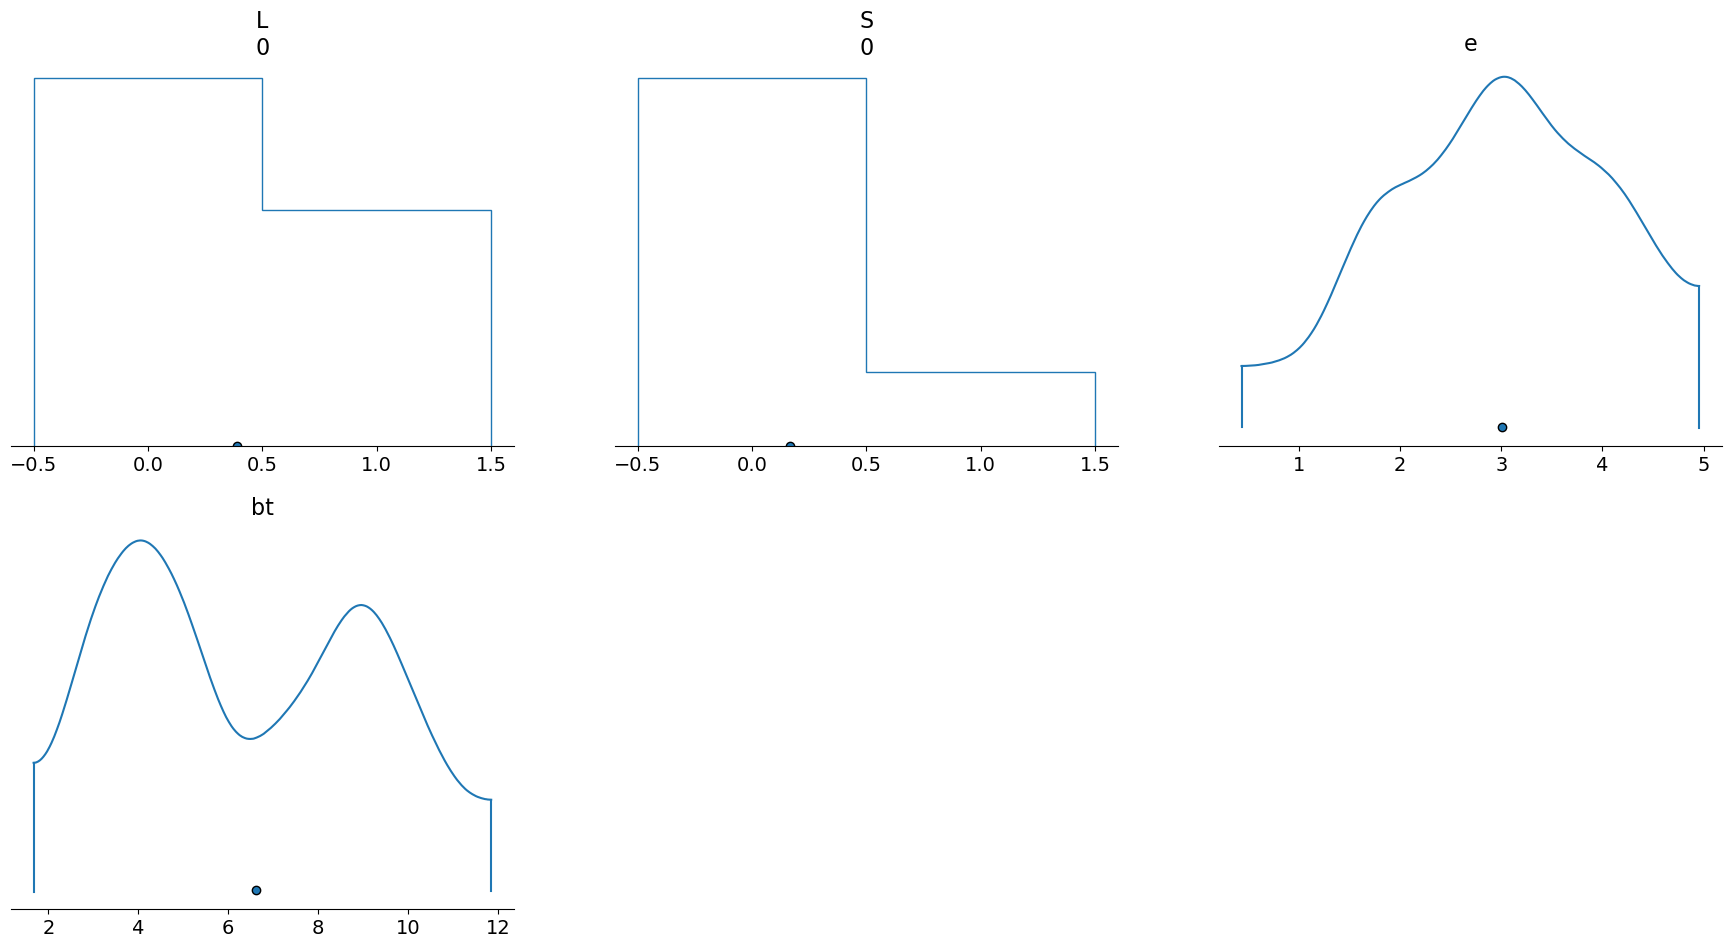

In [4]:
data: az.InferenceData = pm.sample_prior_predictive(draws=500, model=gen_model)
az.plot_density(data["prior"])

## Estimation

So, what did we just do? We made claims about states of the world ($H$) and the generated data ($D$) that was consistent with those claims. In other words, we constructed the sampling distribution $P(D|H)$. However, as we said earlier, that's a bit backwards. We typically don't know what the state of the world is, but we can observe data. The state of the world, $P(H|D)$, is what we want to figure out. Which $H$ is the correct one? You can imagine going through a bunch of $H$ values (i.e. $P(D_0|H_0), P(D_1|H_1), P(D_2|H_2), ..., P(D_n|H_n)$ ) to try to figure out which claim, $H_i$, produces data, $D_i$, that is most consistent with the data, $D$, we observe. The $H_i$ that minimizes the distance between $D_i$ and $D$ is the $H_i$ that is most consistent with the data, and therefore our most informed guess of $H$. (Given a uniform prior or enough data, the appropriately selected $H_i$ would converge with the [maximum likelihood estimate](https://youtu.be/YevSE6bRhTo?si=G_JsnNs3gpRDOsop) of $H$.)

In our case, $H$ is a vector of values $\beta = [\beta_0 + \beta_1 + \beta_2]$:
+ $\beta_0$ is the average build time for small modules with low server load (i.e. the base case)
+ $\beta_1$ is the additional build time for large modules, relative to the base case
+ $\beta_2$ is the additional build time for large server loads, relative to the base case

Finding the right $H$ value amounts to finding the value of $\beta$ that most likely generated the data we saw. If that's our objective, what procedure can we use to identify the right $H$? The key insight is the right value of $H$ is the one for which the probability is highest having observed the data - $\text{max }P(H|D)$ is our best guess. To identify that value, we want to know the probability associated with all values of $H$ (or at least many of them) so we can compare the probabilities and determine the maximum. That is, we want the distribution of probabilities across different values of $H$: $P(H|D)$. Sounds very reasonable, but about that procedure...

### Enter Bayes' Rule

$$ P(H|D) = \frac{P(D|H) P(H)}{P(D)} $$

Bayes rule sounds like a fancy thing that must be memorized, but it's kind of just a logical thing. To simplify our example only a bit, imagine we had two events we were observing: build time and module size. If I have a data set, I would see tuples of observations.

In [5]:
joint_sub: pd.DataFrame = data["prior"][["bt", "S"]].to_dataframe().droplevel(["chain", "S_dim_0"])

joint_sub[:10]

,bt,S
draw,,
0,3.834345,0
1,4.502603,0
2,15.868309,1
3,4.923920,0
4,9.145500,0
5,2.742328,0
6,7.109247,1
7,3.049439,0
8,4.760457,0


This is my *joint probability distribution* of $bt$ and $S$, $P(bt, S)$. Each individual row is a dual-valued draw from my DGP. This idea scales to 3, 4, or $n$ values in each draw if we want. The key is that we observe all of those values together. At any point, I can break this joint distribution down into separate probability distributions. 

$$ P(bt, S) = P(S)P(bt|S) $$

The joint distribution of $bt$ and $S$ is just the probability that we observe a given value of $S$ multiplied by the probability of observing a given value of $bt$ on the subset of data that correspond to that state of $S$.

$$ 
\begin{align}
P(bt=x, S=0) &= P(S=0)P(bt=x|S=0) \\
P(bt=x, S=1) &= P(S=1)P(bt=x|S=1) 
\end{align}
$$

$P(S)$ is just the proportion of times we observe 0 or 1 since it is a binary variable, and the probability distribution of $bt$ for the subset of data for which $S$ is 0 or 1. All we are saying with the conditional probability is, if I observe a large module, I am already in a specific part of the distribution of build times. I can isolate my view to that part of the distribution, which may be different than the build times I see elsewhere, like when modules are small. If I weight that distribution by how often I see it ($P(S)$), I can reason about the frequency with which I observe specific pairs of values. This is easy to see when we plot the data. I am more likely to see longer build times when the module is large.

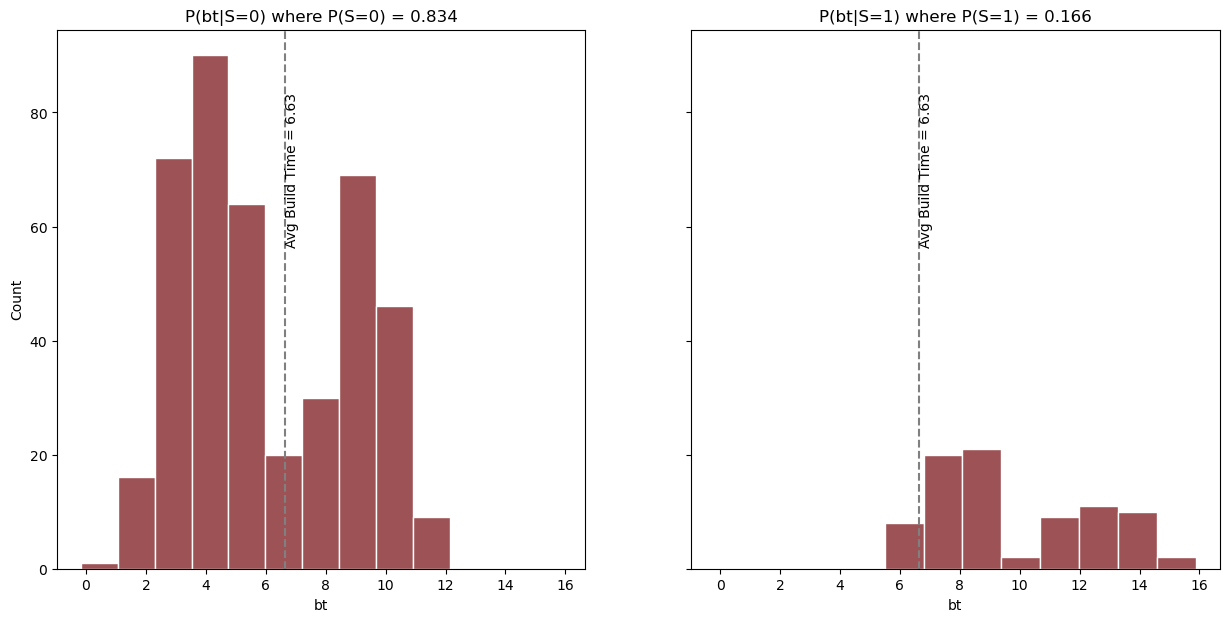

In [6]:
ps0: float = len(joint_sub[joint_sub["S"] == 0]) / float(len(joint_sub))
ps1: float = len(joint_sub[joint_sub["S"] == 1]) / float(len(joint_sub))
bt_s0: pd.DataFrame = joint_sub[joint_sub["S"] == 0]["bt"]
bt_s1: pd.DataFrame = joint_sub[joint_sub["S"] == 1]["bt"]

def plot_hist(data_in: np.array, title: str, ax: plt.Axes) -> plt.Figure:
    sb.histplot(data_in, ax=ax, color="#7d191e", ec="w")
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
plot_hist(data_in=bt_s0, title=f"P(bt|S=0) where P(S=0) = {ps0}", ax=ax[0])
plot_hist(data_in=bt_s1, title=f"P(bt|S=1) where P(S=1) = {ps1}", ax=ax[1])
for a in ax:
    bt_mu:float = joint_sub["bt"].mean()
    a.axvline(x=bt_mu, linestyle="--", color="grey")
    a.annotate(f"Avg Build Time = {round(bt_mu, 2)}", xy=(bt_mu, 70), rotation=90, va="center")

You can think of $P(S)$ as a kind of weight. If we wanted to recover the overall average build time, we can compute it directly as a weighted average of conditional distributions.

$$ 
P(bt=x) = P(S=0)P(bt=x|S=0) + P(S=1)P(bt=x|S=1) 
$$

In [7]:
expected_bt: float = ps0 * bt_s0.mean() + ps1 * bt_s1.mean()
expected_bt

np.float64(6.625735119168569)

Critically, there is no reason we have to break down this joint distribution in only one way.

$$ P(bt, S) = P(S)P(bt|S) = P(bt)(P(S|bt) $$

We are free to decompose it in either direction, which is what gives us a lot of flexibility. Now we can choose what we want to compute based upon what we can observe. If we want to estimate which module size we are observing based upon build times...

$$ P(S|bt) = \frac{P(bt|S)P(S)}{P(bt)} $$

... and if we want to estimate build times based upon the observed module size:

$$ P(bt|S) = \frac{P(S|bt)P(bt)}{P(S)} $$

### Building a Model for Estimation

Now that we know how to generate the conditional probability distribution of interest, let's get back to estimation. In our case...

$$ P(H|D) = \frac{P(D|H) P(H)}{P(D)} $$

...translates to the following:

$$ P(\beta|bt) = \frac{P(bt|\beta) P(\beta)}{P(bt)} $$

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


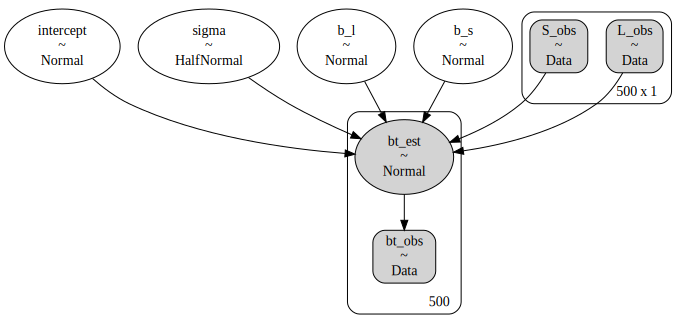

In [37]:
data_dict: Dict[str, np.array] = {c: data["prior"][c].values[0] for c in ["bt", "S", "L"]}

with pm.Model() as est_model:
    # Now we are estimating our coefficients, so we need priors
    beta_0: pt.TensorVariable = pm.Normal(mu=2, sigma=1, name="intercept")
    beta_1: pt.TensorVariable = pm.Normal(mu=3, sigma=2, name="b_s")
    beta_2: pt.TensorVariable = pm.Normal(mu=10, sigma=6, name="b_l")
    beta: pt.TensorVariable = pt.stack([beta_0, beta_1, beta_2])

    # Now we are using actual observed data 
    intercept: pt.TensorConstant = pm.math.constant(np.array([[1]]*len(data_dict["S"])), ndim=2, name="intercept")
    bt_obs: pm.Data = pm.Data("bt_obs", data_dict["bt"])
    s_obs: pm.Data = pm.Data("S_obs", data_dict["S"])
    l_obs: pm.Data = pm.Data("L_obs", data_dict["L"])
    x_data: pt.TensorVariable = pt.concatenate([intercept, s_obs, l_obs],axis=1)

    # Estimate the model based upon observed data
    mu: pt.TensorVariable = pm.math.dot(x_data, beta)
    sigma: pt.TensorVariable = pm.HalfNormal(sigma=1.2, name="sigma")
    bt_est: pt.TensorVariable = pm.Normal("bt_est", mu=mu, sigma=sigma, observed=bt_obs)

    # Draw samples from the posterior distribution
    bt_post = pm.sample(1000)


# pytensor.dprint(est_model.obs)
pm.model_to_graphviz(est_model)

Sampling: [b_l, b_s, bt_est, intercept, sigma]


array([[<Axes: title={'center': 'b_s'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'b_l'}>, <Axes: >, <Axes: >]],
      dtype=object)

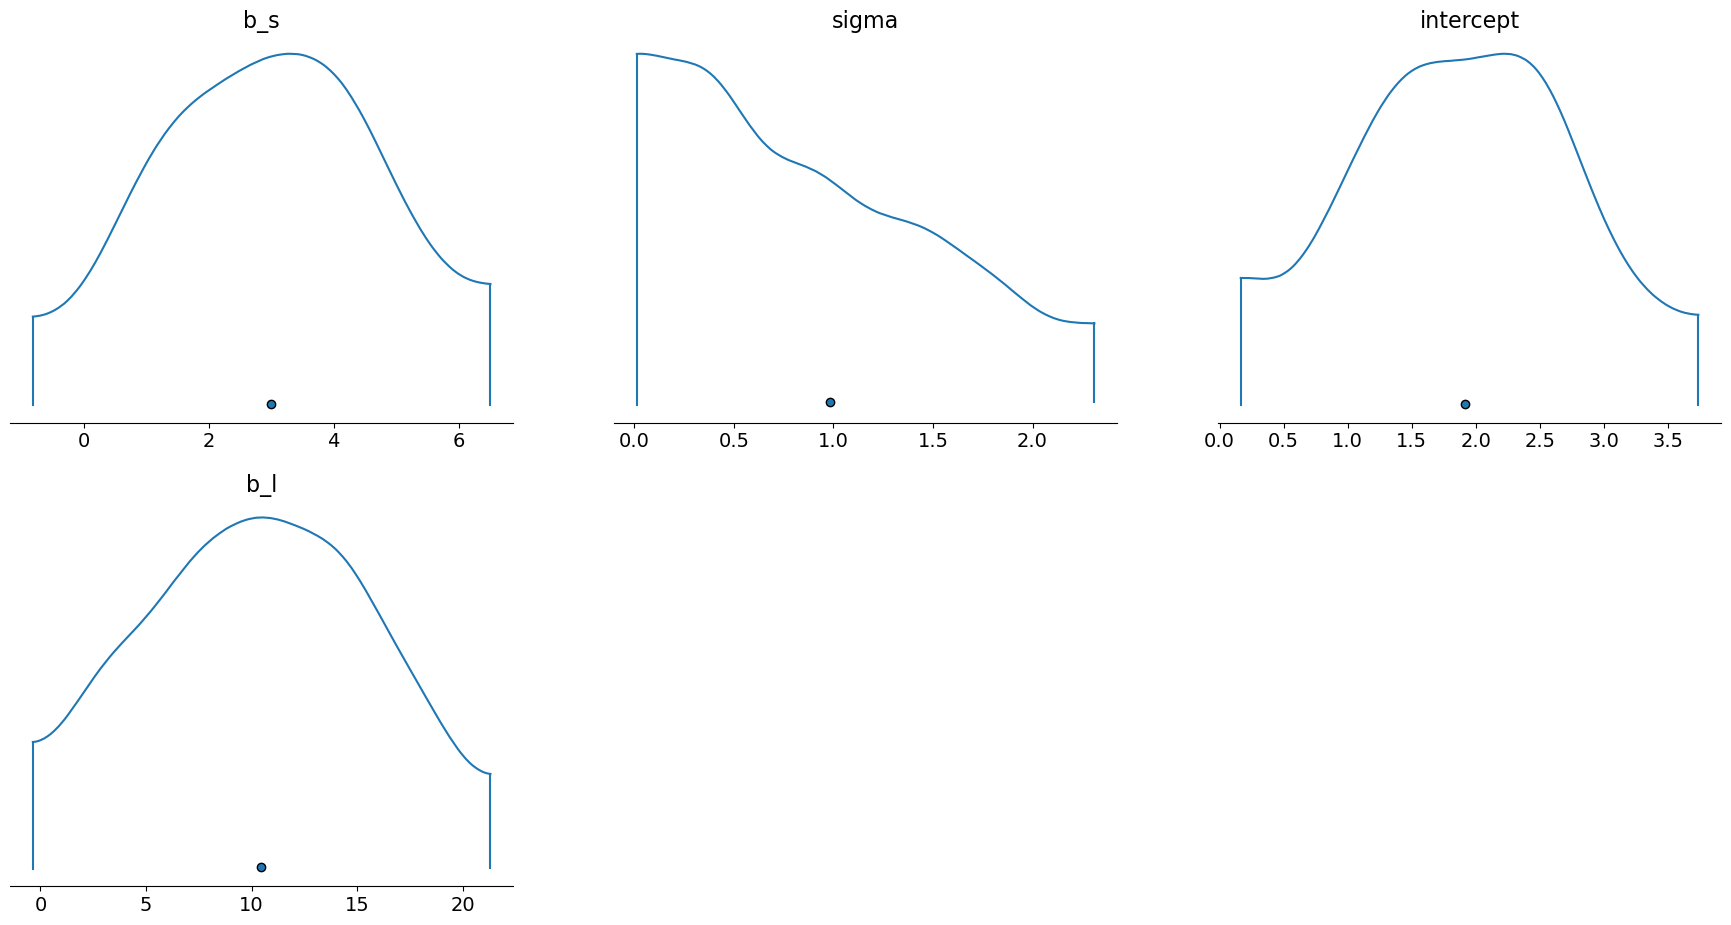

In [13]:
prior_pred: az.InferenceData = pm.sample_prior_predictive(draws=500, model=est_model)
az.plot_density(prior_pred["prior"])

In [10]:
data["prior"][["bt", "S", "L"]].to_dataframe().droplevel(["chain", "S_dim_0", "L_dim_0"])

,bt,S,L
draw,,,
0,3.834345,0,0
1,4.502603,0,0
2,15.868309,1,1
3,4.923920,0,0
4,9.145500,0,1
...,...,...,...
495,8.239285,0,1
496,6.529034,1,0
497,4.191026,0,0
